<a href="https://colab.research.google.com/github/sidm-23/One-Shot-Learning-on-Omniglot-data/blob/master/Omniglot.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
#Importing all the required  modules
%tensorflow_version 1.x
import cv2
import numpy as np
import os
from matplotlib import pyplot as plt
import pandas as pd
from sklearn.utils import shuffle
import tensorflow as tf
from keras.models import Sequential
from keras.optimizers import Adam
from keras.layers import Conv2D, ZeroPadding2D, Activation, Input, concatenate
from keras.models import Model
from keras.layers.normalization import BatchNormalization
from keras.layers.pooling import MaxPooling2D, AveragePooling2D
from keras.layers.merge import Concatenate
from keras.layers.core import Lambda, Flatten, Dense
from keras.initializers import glorot_uniform
from keras.regularizers import l2
from keras import backend as K

The [Omniglot dataset](https://github.com/brendenlake/omniglot) is a collection of 1623 hand-drawn characters from 50 alphabets. For every character there are just 20 examples, each drawn by a different person at resolution 105x105. Each image is paired with stroke data, a sequence of [x,y,t] coordinates with time (t) in milliseconds. This data is split as 30 alphabets used for training and the other 20 used for validation of the model.


**Why use One-Shot Learning**     
In conventional image processing, an image is put through a CNN(Convolution Neural Network) to extract features from which an object/edge is detected or classified, but this is very computationally intense and requires a very large training set to alleviate all bias. Another issue is that when a new set of training data is added the model has to be re-trained.
So one-shot learning proposes to extract features from a small set of training data and make a faster prediction based on similarity.  
*Ex* 
Face unlock in phones take only multiple images of and feature for your face and store it on device but when a new face is added it does not have re-train the entire model, it extracts the features from each image and compares for similarity thus reducing the time it takes to unlock while still being reliable.

**Data Preprocessing**

**Raw data** 
>image_background  
>>Gujarati
>>>Character01
>>>>20 images

![Raw Dataset](https://raw.githubusercontent.com/brendenlake/omniglot/master/omniglot_grid.jpg)



















In [0]:
def get_image_data(folder):

    """
    Get Training and evaluation data for images
    It returns the data in a DataFrame with multiple indexes
    """
    
    lang_list=[]#list of of languages
    X={}
    Y={}
    for languages in os.listdir(folder):
        if languages.startswith('.'):
            continue#ignore all hidden files
        else:
            images={}
            lang_list.append(languages)#for each language
            chars=[]
            for alphabets in os.listdir(folder+languages):
                im=[]
                chars.append(alphabets)#for each character
                for character in os.listdir(folder+languages+"/"+alphabets):
                    if(character.startswith('.')):
                        continue
                    else:
                        im.append(cv2.imread(folder+languages+"/"+alphabets+"/"+character))#append image data
                images[alphabets]=im#for each character
                Y[languages]=chars#for each language type
#             print(languages)
            X[languages]=images
            
    #After getting all data return the data in Serires and a Dataframe to easily access the data
    y=pd.Series(Y)
    x=pd.DataFrame.from_dict({(i,j): X[i][j] 
                               for i in X.keys() 
                               for j in X[i].keys()},orient='index')
    
    return x,y,lang_list

In [17]:
#testing module
print("Getting Trainind data")
x_train,y_train,languages=get_image_data('Fellowship/images_background/')
print('Getting Evaluation data')
x_val,y_val,languages_val=get_image_data('Fellowship/images_evaluation/')

Getting Trainind data
Getting Evaluation data


**After reading data**  
The data is now stored a multi-indexed DataFrame, with each cell storing the image array to the corresponding language and character. This makes accessing the image data very easy and fast as pandas DataFrame structure is very well optimized.

In [7]:
x_val

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
"(Kannada, character38)","[[[255, 255, 255], [255, 255, 255], [255, 255,...","[[[255, 255, 255], [255, 255, 255], [255, 255,...","[[[255, 255, 255], [255, 255, 255], [255, 255,...","[[[255, 255, 255], [255, 255, 255], [255, 255,...","[[[255, 255, 255], [255, 255, 255], [255, 255,...","[[[255, 255, 255], [255, 255, 255], [255, 255,...","[[[255, 255, 255], [255, 255, 255], [255, 255,...","[[[255, 255, 255], [255, 255, 255], [255, 255,...","[[[255, 255, 255], [255, 255, 255], [255, 255,...","[[[255, 255, 255], [255, 255, 255], [255, 255,...","[[[255, 255, 255], [255, 255, 255], [255, 255,...","[[[255, 255, 255], [255, 255, 255], [255, 255,...","[[[255, 255, 255], [255, 255, 255], [255, 255,...","[[[255, 255, 255], [255, 255, 255], [255, 255,...","[[[255, 255, 255], [255, 255, 255], [255, 255,...","[[[255, 255, 255], [255, 255, 255], [255, 255,...","[[[255, 255, 255], [255, 255, 255], [255, 255,...","[[[255, 255, 255], [255, 255, 255], [255, 255,...","[[[255, 255, 255], [255, 255, 255], [255, 255,...","[[[255, 255, 255], [255, 255, 255], [255, 255,..."
"(Kannada, character35)","[[[255, 255, 255], [255, 255, 255], [255, 255,...","[[[255, 255, 255], [255, 255, 255], [255, 255,...","[[[255, 255, 255], [255, 255, 255], [255, 255,...","[[[255, 255, 255], [255, 255, 255], [255, 255,...","[[[255, 255, 255], [255, 255, 255], [255, 255,...","[[[255, 255, 255], [255, 255, 255], [255, 255,...","[[[255, 255, 255], [255, 255, 255], [255, 255,...","[[[255, 255, 255], [255, 255, 255], [255, 255,...","[[[255, 255, 255], [255, 255, 255], [255, 255,...","[[[255, 255, 255], [255, 255, 255], [255, 255,...","[[[255, 255, 255], [255, 255, 255], [255, 255,...","[[[255, 255, 255], [255, 255, 255], [255, 255,...","[[[255, 255, 255], [255, 255, 255], [255, 255,...","[[[255, 255, 255], [255, 255, 255], [255, 255,...","[[[255, 255, 255], [255, 255, 255], [255, 255,...","[[[255, 255, 255], [255, 255, 255], [255, 255,...","[[[255, 255, 255], [255, 255, 255], [255, 255,...","[[[255, 255, 255], [255, 255, 255], [255, 255,...","[[[255, 255, 255], [255, 255, 255], [255, 255,...","[[[255, 255, 255], [255, 255, 255], [255, 255,..."
"(Kannada, character16)","[[[255, 255, 255], [255, 255, 255], [255, 255,...","[[[255, 255, 255], [255, 255, 255], [255, 255,...","[[[255, 255, 255], [255, 255, 255], [255, 255,...","[[[255, 255, 255], [255, 255, 255], [255, 255,...","[[[255, 255, 255], [255, 255, 255], [255, 255,...","[[[255, 255, 255], [255, 255, 255], [255, 255,...","[[[255, 255, 255], [255, 255, 255], [255, 255,...","[[[255, 255, 255], [255, 255, 255], [255, 255,...","[[[255, 255, 255], [255, 255, 255], [255, 255,...","[[[255, 255, 255], [255, 255, 255], [255, 255,...","[[[255, 255, 255], [255, 255, 255], [255, 255,...","[[[255, 255, 255], [255, 255, 255], [255, 255,...","[[[255, 255, 255], [255, 255, 255], [255, 255,...","[[[255, 255, 255], [255, 255, 255], [255, 255,...","[[[255, 255, 255], [255, 255, 255], [255, 255,...","[[[255, 255, 255], [255, 255, 255], [255, 255,...","[[[255, 255, 255], [255, 255, 255], [255, 255,...","[[[255, 255, 255], [255, 255, 255], [255, 255,...","[[[255, 255, 255], [255, 255, 255], [255, 255,...","[[[255, 255, 255], [255, 255, 255], [255, 255,..."
"(Kannada, character03)","[[[255, 255, 255], [255, 255, 255], [255, 255,...","[[[255, 255, 255], [255, 255, 255], [255, 255,...","[[[255, 255, 255], [255, 255, 255], [255, 255,...","[[[255, 255, 255], [255, 255, 255], [255, 255,...","[[[255, 255, 255], [255, 255, 255], [255, 255,...","[[[255, 255, 255], [255, 255, 255], [255, 255,...","[[[255, 255, 255], [255, 255, 255], [255, 255,...","[[[255, 255, 255], [255, 255, 255], [255, 255,...","[[[255, 255, 255], [255, 255, 255], [255, 255,...","[[[255, 255, 255], [255, 255, 255], [255, 255,...","[[[255, 255, 255], [255, 255, 255], [255, 255,...","[[[255, 255, 255], [255, 255, 255], [255, 255,...","[[[255, 255, 255], [255, 255, 255], [255, 255,...","[[[255, 255, 255], [255, 255, 255], [255, 255,...","

**Siamese Network**  
This is the architecture we use for our one-shot classification. It takes an input of two sets of images and finds the similarity of each pair and finds the twins.
This is done by passing it through 4 layer CNN which return 4096 features for each image, we then find the difference between features of each image and use activation function to signal the similarity if the images.



In [0]:
def siamese_net():
    
    """
    Define the architecture of the model which is convolution neural network with 64 10x10 filters,
    relu -> max pool -> convolution with 128 7x7 filters, relu -> max pool -> convolution with 128 4x4 filters,
    relu -> max pool -> convolution with 256 4x4 filters.
    """
    
    def initialize_weights(shape, dtype=None ,name=None):
        """
        The paper, http://www.cs.utoronto.ca/~gkoch/files/msc-thesis.pdf
        suggests to initialize CNN layer weights with mean as 0.0 and standard deviation of 0.01
        """
        return np.random.normal(loc = 0.0, scale = 1e-2, size = shape)

    def initialize_bias(shape, dtype=None, name=None):
        """
        The paper, http://www.cs.utoronto.ca/~gkoch/files/msc-thesis.pdf
        suggests to initialize CNN layer bias with mean as 0.5 and standard deviation of 0.01
        """
        return np.random.normal(loc = 0.5, scale = 1e-2, size = shape)

    #Define Imput shape 
    input_shape=(105,105,3)
    left_input=Input(input_shape)
    right_input=Input(input_shape)

    """
    Creating a 4 layer model 
    """
    model=Sequential()
    model.add(Conv2D(filters=64,kernel_size=(10,10),activation='relu',
                 input_shape=input_shape,kernel_initializer=initialize_weights,kernel_regularizer=l2(2e-4)))
    model.add(MaxPooling2D())

    model.add(Conv2D(128,(7,7),activation='relu',kernel_initializer=initialize_weights,
                 bias_initializer=initialize_bias,kernel_regularizer=l2(2e-4)))
    model.add(MaxPooling2D())

    model.add(Conv2D(128,(4,4),activation='relu',kernel_initializer=initialize_weights,
                 bias_initializer=initialize_bias,kernel_regularizer=l2(2e-4)))
    model.add(MaxPooling2D())

    model.add(Conv2D(256,(4,4),activation='relu',kernel_initializer=initialize_weights,
                 bias_initializer=initialize_bias,kernel_regularizer=l2(2e-4)))
    model.add(Flatten())

    model.add(Dense(4096,activation='sigmoid',kernel_regularizer=l2(1e-3),kernel_initializer=initialize_weights,
         bias_initializer=initialize_bias))

    encode_l=model(left_input)
    encode_r=model(right_input)

    l1_layer=Lambda(lambda tensors:K.abs(tensors[0]-tensors[1]))
    l1_distance=l1_layer([encode_l,encode_r])

    # Add a dense layer with a sigmoid unit to generate the similarity score
    prediction = Dense(1,activation='sigmoid',bias_initializer=initialize_bias)(l1_distance)
    
    # Connect the inputs with the outputs
    siamese_net = Model(inputs=[left_input,right_input],outputs=prediction)

    print(siamese_net.summary())
    return siamese_net

In [19]:
#Create and complie model
model=siamese_net()
optimizer = Adam(lr = 0.00006)
model.compile(loss="binary_crossentropy",optimizer=optimizer)

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 105, 105, 3)  0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            (None, 105, 105, 3)  0                                            
__________________________________________________________________________________________________
sequential_2 (Sequential)       (None, 4096)         38960448    input_3[0][0]                    
                                                                 input_4[0][0]                    
__________________________________________________________________________________________________
lambda_2 (Lambda)               (None, 4096)         0           sequential_2[1][0]         

**Training**

In [0]:
# Hyper parameters
evaluate_every =200 # interval for evaluating on one-shot tasks
batch_size = 32 #batch size to train data on
n_iter = 2000 # No. of training iterations

In [0]:
def get_batch(x):
  """
  Create batch to train the model
  We create 32 pair of images the first 16 are images with same class and for next
  half we ensure that that the pairs are not from the same category.
  """
  n_classes, n_examples= x.shape
  w, h =105,105
  categories=np.random.choice(n_classes,size=(batch_size,),replace=False)

  # initialize 2 empty arrays for the input image batch
  pairs=[np.zeros((batch_size, h, w,3)) for i in range(2)]
    
  # initialize vector for the targets
  targets=np.zeros((batch_size,))

  targets[batch_size//2:]=1
  for i in range(batch_size):
      category=categories[i]
      idx_1=np.random.randint(0,n_examples)
      pairs[0][i,:,:,:] = x.iat[category, idx_1]
      idx_2 = np.random.randint(0, n_examples)
      if i >= batch_size // 2:
              category_2 = category  
      else: 
          # add a random number to the category modulo n classes to ensure 2nd image has a different category
          category_2 = (category + np.random.randint(1,n_classes)) % n_classes
      pairs[1][i,:,:,:] = x.iat[category_2,idx_2]
    
  return pairs,targets
    

In [22]:
print("Starting training process!")
l=[]
for i in range(1, n_iter+1):
    inputs,targets = get_batch(x_train)
    loss = model.train_on_batch(inputs,targets)
    l.append(loss)
    if i % evaluate_every == 0:
        print("\n ------------- \n")
        print("Train Loss: {0}".format(loss))

Starting training process!

 ------------- 

Train Loss: 2.3495733737945557

 ------------- 

Train Loss: 1.7542649507522583

 ------------- 

Train Loss: 1.4156267642974854

 ------------- 

Train Loss: 1.1413341760635376

 ------------- 

Train Loss: 1.0137253999710083

 ------------- 

Train Loss: 1.0075879096984863

 ------------- 

Train Loss: 0.8550300002098083

 ------------- 

Train Loss: 0.908806324005127

 ------------- 

Train Loss: 0.6087885499000549

 ------------- 

Train Loss: 0.7647333145141602


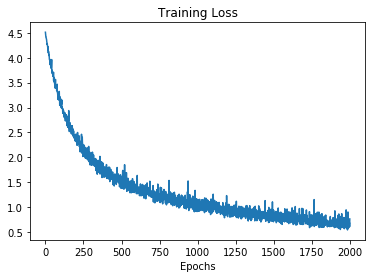

In [23]:
plt.title('Training Loss')
plt.xlabel('Epochs')
plt.plot(l)

As seen loss has decreased for each epoch, now we can move on to test our model.

**Testing**

In [0]:
def make_test_batch(N):
    """
    Create test batch
    We create a pair of an image set first part containing the test_image(the image for which similarity is checked)
    second part contains set of N images. We use shuffle so that the first image in support-set is not always from the same classs
    """
    n_classes, n_examples= x_val.shape
    w, h =105,105
    categories=languages_val


    indices=m=np.random.randint(0,n_examples,size=(N,))#choose random images to be selected
    categories=np.random.randint(n_classes,size=(N,))
    test_image=np.zeros((1,w,h,3))#placehoder for test image

    targets=np.zeros((N,))
    support_set=[]
    targets[0] = 1
    true_category = categories[0]
    ex1, ex2 = np.random.choice(n_examples,replace=False,size=(2,))
    test_image[0] = np.asarray(x_val.iat[true_category,ex1])
    for c,i in zip(categories,indices):
        support_set.append(x_val.iat[c,i])
    support_set[0] = x_val.iat[true_category,ex2]
    support_set=np.array(support_set)
    targets,support_set = shuffle(targets,support_set)#shuffle the images 
    pairs = [test_image,support_set]
    return pairs,targets

In [0]:
def testing(k,N):
  """
  Used to test model for k times on N-batch size data
  """
  n_correct=0
  for i in range(k):
      inputs_t, targets_t = make_test_batch(N)
      probs = model.predict_on_batch(inputs_t)
      if np.argmax(probs) == np.argmax(targets_t):
          n_correct+=1
  ImageLoader(inputs_t)#showcase last batch images for example
  percent_correct = (100.0 * n_correct / k)
  print("Got an average of "+str(percent_correct)+"% for "+str(N)+" way one-shot learning accuracy \n")
  # return percent_correct


In [0]:
def ImageLoader(imlist):
  """
  The images are loaded and displayed showcasing the test-image 
  and the support-set of images to which it is compared to.
  """
  plt.subplots()
  plt.title("Test Image")
  plt.imshow(imlist[0][0])
  plt.subplots()
  img=concat_images(imlist[1])
  plt.title("Support-set image")
  plt.imshow(img)
  plt.show()

In [0]:
def concat_images(X):
    """
    Concatenates a bunch of images into a big matrix since mutiple images cant be plotted together.
    """
    nc, h , w, _ = X.shape
    n = np.ceil(np.sqrt(nc)).astype("int8")
    img = np.zeros((n*w,n*h,3))
    x = 0
    y = 0
    for example in range(nc):
        img[x*w:(x+1)*w,y*h:(y+1)*h] = X[example]
        y += 1
        if y >= n:
            y = 0
            x += 1
    return img


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


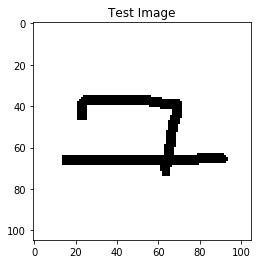

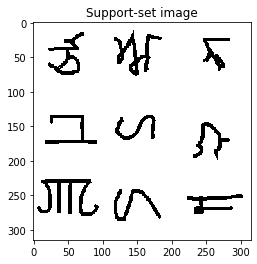

Got an average of 95.0% for 9 way one-shot learning accuracy 



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


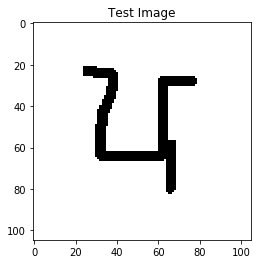

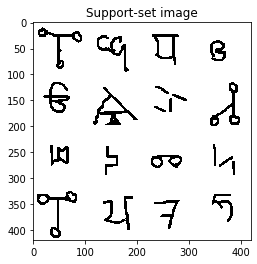

Got an average of 55.0% for 16 way one-shot learning accuracy 



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


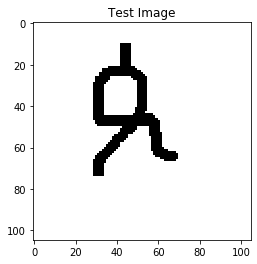

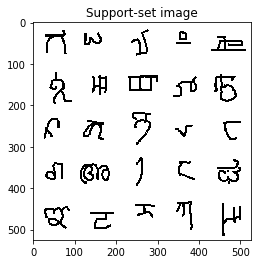

Got an average of 75.0% for 25 way one-shot learning accuracy 



In [30]:
"""
The main cell the testing fuction is called for diifrent N-way One-shot classification 
"""
N_way=[9,16,25]
for i in N_way:
  testing(20,i)

**Conclusions**  
The Hyperparameters can te tuned more to get better results and avoid over-fitting.
Future work should also use stroke data for better classification and handwriting recognition.

**Stroke Data**

In [0]:
def get_stroke(fp):

  """
  Opens the stroke data file and add stroke data, each start and break shows the start and end of a motor(i.e 1 movement of hand). 
  Multiple strokes make 1 motor and it is sent back to be stored in DataFrame.
  """
  with open(fp,'r') as f:
        stroke_data=f.readlines()
        stroke_data=[l.strip() for l in stroke_data]
        motor=[]
        for line in stroke_data:
            if line=="START":
                stk=[]
            elif line=="BREAK":
                stk = np.array(stk)
                motor.append(stk) # add to list of strokes
                stk = [] 
            else:
                arr = np.fromstring(line,dtype=float,sep=',')
                stk.append(arr)
  return motor

In [0]:
def get_stroke_data(folder):
    """
    Function to get stroke data and returns a dataframe in accordance to language and character 
    """
    lang_list=[]
    SX={}
    for languages in os.listdir(folder):
        if languages.startswith('.'):
            continue
        else:
            strokes={}
            lang_list.append(languages)
            for alphabets in os.listdir(folder+languages):
                if alphabets.startswith('.'):
                    continue
                else:
                    stk=[]
                    for character in os.listdir(folder+languages+"/"+alphabets):
                        if(character.startswith('.')):
                            continue
                        else:
                            stk_data=get_stroke(folder+languages+"/"+alphabets+"/"+character)
                            stk.append(stk_data)
                    strokes[alphabets]=stk
            
        SX[languages]=strokes
    
    sx=pd.DataFrame.from_dict({(i,j): SX[i][j] 
                           for i in SX.keys() 
                           for j in SX[i].keys()},orient='index')
    return sx

In [0]:
def draw_stroke(motor):
  """
  Draw the each alphabet
  """
  drawing=[d[:,0:2]for d in motor]
  for i in drawing:
      plt.plot(i[:,0],i[:,1])

In [39]:
print("Getting stroke train data")
stroke_train=get_stroke_data('Fellowship/strokes_background/')
print("Getting stroke validation data")
stroke_test=get_stroke_data('Fellowship/strokes_evaluation/')

Getting stroke train data
Getting stroke validation data


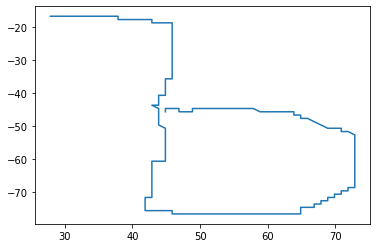

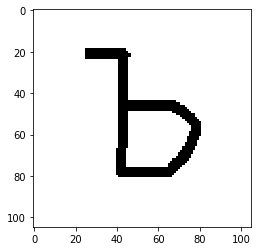

In [40]:
#Example showcasing the how stroke data is stored
draw_stroke(stroke_train.iloc[137,1])
plt.show()
plt.subplots()
plt.imshow(x_train.iloc[137,1])

In [14]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [0]:
!unzip -uq "/content/drive/My Drive/Colab Notebooks/Fellowship"